In [2]:
!pip install gast==0.2.2
!pip install tensorflow==1.15
!pip install tensorflow_hub>=0.6.0
!pip3 install tensorflow_text==1.15

  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=9184276f3589572aee8dbdba2e1d7920f28a61075b504eaba56e8d4f7896530a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 512kB 46.7MB/s 
     |████████████████████████████████| 3.8MB 44.3MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found 

In [3]:
!pip3 install seqeval

     |████████████████████████████████| 51kB 6.7MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=a0ac75cd358cab8ba9885f185bc2f98619cc8e7e79c77c0d82e663fca53accd0
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
downloaded = drive.CreateFile({'id':"1j8_XsnH3IhqoBXGm6S9aP7Aa_D4aqXbz"})   
downloaded.GetContentFile('chap4_mahabharath_annotations.csv') 

# New section

In [7]:
import pandas as pd
annotations = pd.read_csv("chap4_mahabharath_annotations.csv", index_col=['id'])

In [8]:
annotations

,sentence#,token,tag
id,,,
0,0,Om,CONCEPT
1,0,!,O
2,1,Having,O
3,1,bowed,O
4,1,down,O
...,...,...,...
830510,34331,The,O
830511,34331,end,O
830512,34331,of,O


In [9]:
words = list(annotations['token'].values)
words.append('PADword')
n_words = len(set(words))
n_words, len(words)

(19573, 830516)

In [10]:
tags = list(set(annotations["tag"].values))
n_tags = len(tags)
print(n_tags)
tags

12


['WATER',
 'PLANT',
 'CONCEPT',
 'WEAPON',
 'SPECIAL_OBJECT',
 'TITLE',
 'BOOK',
 'PLACE',
 'GROUP',
 'PERSON',
 'O',
 'ANIMAL']

In [11]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [12]:
getter = SentenceGetter(annotations)
sent = getter.get_next()
print(sent)

[('Om', 'CONCEPT'), ('!', 'O')]


In [13]:
sentences = getter.sentences
print(len(sentences))

34332


In [14]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 428 words


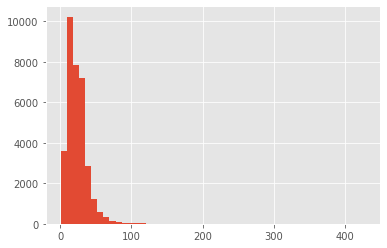

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
plt.hist([len(s) for s in sentences], bins = 50)
plt.show()

In [17]:
max_len = 50
X = [[w[0] for w in s] for s in sentences]
Y = [[w[1] for w in s] for s in sentences]
new_X = []
y_label = []
for k in range(len(X)):
    seq = X[k]
    j = 0
    while(j<len(seq)):
        new_seq = []
        new_y = []
        for i in range(j,j+max_len):
            try:
                new_seq.append(seq[i])
                new_y.append(Y[k][i])
            except:
                new_seq.append("PADword")
                new_y.append('O')
        new_X.append(new_seq)
        y_label.append(new_y)
        j=i+1

In [45]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

living_entity_tags = ['ANIMAL','PERSON','GROUP','TITLE']
non_living_entity_tags = ['BOOK','PLACE','WEAPON','SPECIAL_OBJECT','PLANT','CONCEPT','WATER']

#for extraction of entities
# tags2index = {}
# for tag in tags:
#     if tag not in living_entity_tags:
#         tags2index[tag] = 0
#     else:
#         tags2index[tag] = 1
        
tags2index = {t:i for i,t in enumerate(tags)}
y=[]        
for labels in y_label:
    word_tag = []
    for label in labels:
#         print(label)
        word_tag.append(tags2index[label])
    y.append(np.array(word_tag))
tags2index

{'ANIMAL': 11,
 'BOOK': 6,
 'CONCEPT': 2,
 'GROUP': 8,
 'O': 10,
 'PERSON': 9,
 'PLACE': 7,
 'PLANT': 1,
 'SPECIAL_OBJECT': 4,
 'TITLE': 5,
 'WATER': 0,
 'WEAPON': 3}

In [46]:
y = np.array(y)

In [49]:
y[0]

array([ 2, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [48]:
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import add, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
import seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

batch_size = 32
def ElmoEmbedding(x):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x,tf.string)),
                              "sequence_len": tf.constant(batch_size*[max_len])},
                      signature="tokens",
                      as_dict=True)["elmo"]

X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2021)

In [50]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import backend as K

sess = tf.compat.v1.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [52]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import add
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda



input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2) )(x)
x = add([x, x_rnn])  
out = TimeDistributed(Dense(12, activation="softmax"))(x)
# out = TimeDistributed(Dense(2, activation="softmax"))(x)
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [53]:
len(X_tr), len(X_te), batch_size,len(X_tr)/batch_size, len(X_te)/batch_size 

(32470, 3608, 32, 1014.6875, 112.75)

In [54]:
X_tr, X_val = X_tr[:914*batch_size], X_tr[-100*batch_size:]
y_tr, y_val = y_tr[:914*batch_size], y_tr[-100*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [55]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),batch_size=batch_size, epochs=3, verbose=1)

Train on 29248 samples, validate on 3200 samples
Epoch 1/3
29248/29248 [==============================] - 447s 15ms/sample - loss: 0.0169 - acc: 0.9955 - val_loss: 0.0069 - val_acc: 0.9981
Epoch 2/3
29248/29248 [==============================] - 448s 15ms/sample - loss: 0.0064 - acc: 0.9982 - val_loss: 0.0060 - val_acc: 0.9984
Epoch 3/3
29248/29248 [==============================] - 447s 15ms/sample - loss: 0.0044 - acc: 0.9988 - val_loss: 0.0054 - val_acc: 0.9982


In [56]:
X_te = X_te[:112*batch_size]
y_te = y_te[:112*batch_size]
preds = model.predict(np.array(X_te), verbose=1, batch_size=batch_size)

3584/3584 [==============================] - 33s 9ms/sample


In [58]:
# in case of classification
idx2tag = {i: w for w, i in tags2index.items()}

# in case of extraction of entities
# idx2tag = {}
# for k,v in tags2index.items():
#     if v == 0:
#         idx2tag[v] = 'O'
#     else:
#         idx2tag[v] = "ENTITY"
        
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out

In [59]:
pred_labels = pred2label(preds)

In [60]:
test_labels = test2label(y_te)

In [62]:
print(classification_report(pred_labels, test_labels))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PERSON seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ANIMAL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOOK seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: GROUP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TITLE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171

               precision    recall  f1-score   support

         ATER       0.74      0.91      0.81        53
        EAPON       0.50      1.00      0.67        14
        ERSON       0.98      0.93      0.96      3004
         ITLE       0.91      0.98      0.95       300
         LACE       0.78      0.81      0.79       165
         LANT       0.59      0.52      0.55        25
        NIMAL       0.22      0.49      0.30        43
       ONCEPT       0.86      0.73      0.79       177
          OOK       0.88      0.98      0.93       194
PECIAL_OBJECT       0.36      0.87      0.51        15
         ROUP       0.95      0.98      0.97       592

    micro avg       0.93      0.93      0.93      4582
    macro avg       0.71      0.84      0.75      4582
 weighted avg       0.94      0.93      0.93      4582

